# Windfields

This notebook is for downloading typhoon tracks from
IBTrACS and generating the windfields.

TODOs:

- Get the full list of track IDs from IBTraCS (link is below)
- Add interpolation between the timesteps
- Understand if we need to change any of the input parameters
  to the climada methods
- Aggregate up to a 0.1 deg grid and save output

In [379]:
%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [380]:
from pathlib import Path
import os

from climada.hazard import Centroids, TCTracks, TropCyclone
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr

## Get typhoon data

Typhoon IDs from IBTrACS are taken from 
[here](https://ncics.org/ibtracs/index.php?name=browse-name)

In [381]:
# Import list of typhoons to a dataframe
typhoons_df = pd.read_csv("typhoons.csv")
typhoons_df

,typhoon_id,typhoon_name,typhoon_year
0,2006329N06150,DURIAN,2006
1,2008169N08135,FENGSHEN,2008
2,2009268N14128,KETSANA,2009
3,2010191N12138,CONSON,2010
4,2011266N13139,NESAT,2011
5,2012331N03157,BOPHA,2012
6,2013282N14132,NARI,2013
7,2013301N13142,KROSA,2013
8,2013306N07162,HAIYAN,2013
9,2013259N17132,USAGI,2013


In [382]:
# Download all tracks from the west pacific basin
sel_ibtracs = TCTracks.from_ibtracs_netcdf(
    provider="usa", year_range=(2006, 2022), basin="WP"
)
sel_ibtracs.size

2022-11-24 10:42:00,784 - climada.hazard.tc_tracks - WARNING - 18 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


494

In [383]:
# Get_track returns the first matching track based
# on the track ID. Interpolate from 3 hours to
# 30 minute intervals to create a smooth intensity field.
tc_tracks = TCTracks()
for typhoon_id in typhoons_df["typhoon_id"]:
    tc_track = sel_ibtracs.get_track(typhoon_id)
    tc_track = tc_track.interp(
        time=pd.date_range(
            tc_track.time.values[0], tc_track.time.values[-1], freq="30T"
        )
    )
    tc_tracks.append(tc_track)

display(tc_tracks.data[:1])

[<xarray.Dataset>
 Dimensions:                 (time: 733)
 Coordinates:
     lat                     (time) float64 6.1 6.118 6.137 ... 11.66 11.68 11.7
     lon                     (time) float64 149.8 149.7 149.6 ... 81.93 81.8
   * time                    (time) datetime64[ns] 2006-11-24T12:00:00 ... 200...
 Data variables:
     time_step               (time) float64 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0
     radius_max_wind         (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
     radius_oci              (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
     max_sustained_wind      (time) float64 15.0 15.0 15.0 ... 15.0 15.0 15.0
     central_pressure        (time) float64 1.006e+03 1.006e+03 ... 1.006e+03
     environmental_pressure  (time) float64 1.008e+03 1.008e+03 ... 1.006e+03
     basin                   (time) <U2 'WP' 'WP' 'WP' 'WP' ... 'NI' 'NI' 'NI'
 Attributes:
     max_sustained_wind_unit:  kn
     central_pressure_unit:    mb
     name:                     DURIA

<GeoAxesSubplot:>

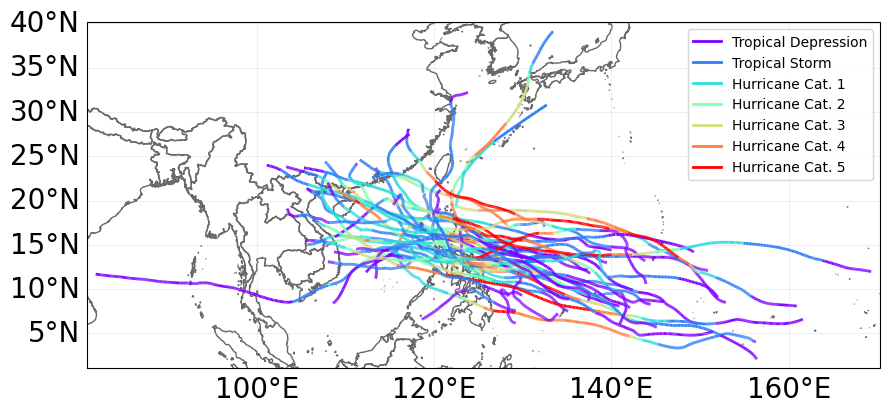

In [384]:
# Plot the tracks
# Takes a while, especially after the interpolation.
tc_tracks.plot()

## Construct the windfield

The typhoon tracks will be used to construct the wind field.
The wind field grid will be set using a geopackage file that is
used for all other grid-based data.

In [385]:
# input_dir = (Path(os.getenv("STORM_DATA_DIR"))/ "analysis/02_new_model_input/input")
# filepath = input_dir / "phl_0.1_degree_grid_centroids.gpkg"
# gdf = gpd.read_file(filepath)

filepath = "input/phl_0.1_degree_grid_centroids.gpkg"
gdf = gpd.read_file(filepath)

gdf

,id,left,top,right,bottom,Area,AreainKM,Len,Longitude,Latitude,Centroid,geometry
0,1.0,114.25,21.15,114.35,21.05,1.150374e+08,115.037,10.72555,114.3,21.1,114.3E_21.1N,POINT (114.30000 21.10000)
1,2.0,114.25,21.05,114.35,20.95,1.151129e+08,115.113,10.72907,114.3,21.0,114.3E_21N,POINT (114.30000 21.00000)
2,3.0,114.25,20.95,114.35,20.85,1.151881e+08,115.188,10.73257,114.3,20.9,114.3E_20.9N,POINT (114.30000 20.90000)
3,4.0,114.25,20.85,114.35,20.75,1.152629e+08,115.263,10.73606,114.3,20.8,114.3E_20.8N,POINT (114.30000 20.80000)
4,5.0,114.25,20.75,114.35,20.65,1.153373e+08,115.337,10.73952,114.3,20.7,114.3E_20.7N,POINT (114.30000 20.70000)
...,...,...,...,...,...,...,...,...,...,...,...,...
20745,20746.0,126.65,5.05,126.75,4.95,1.226348e+08,122.635,11.07406,126.7,5.0,126.7E_5N,POINT (126.70000 5.00000)
20746,20747.0,126.65,4.95,126.75,4.85,1.226529e+08,122.653,11.07488,126.7,4.9,126.7E_4.9N,POINT (126.70000 4.90000)
20747,20748.0,126.65,4.85,126.75,4.75,1.226705e+08,122.671,11.07567,126.7,4.8,126.7E_4.8N,POINT (126.70000 4.80000)
20748,20749.0,126.65,4.75,126.75,4.65,1.226879e+08,122.688,11.07646,126.7,4.7,126.7E_4.7N,POINT (126.70000 4.70000)


2022-11-24 10:42:54,741 - climada.util.plot - WARNING - Error parsing coordinate system 'epsg:4326'. Using projection PlateCarree in plot.


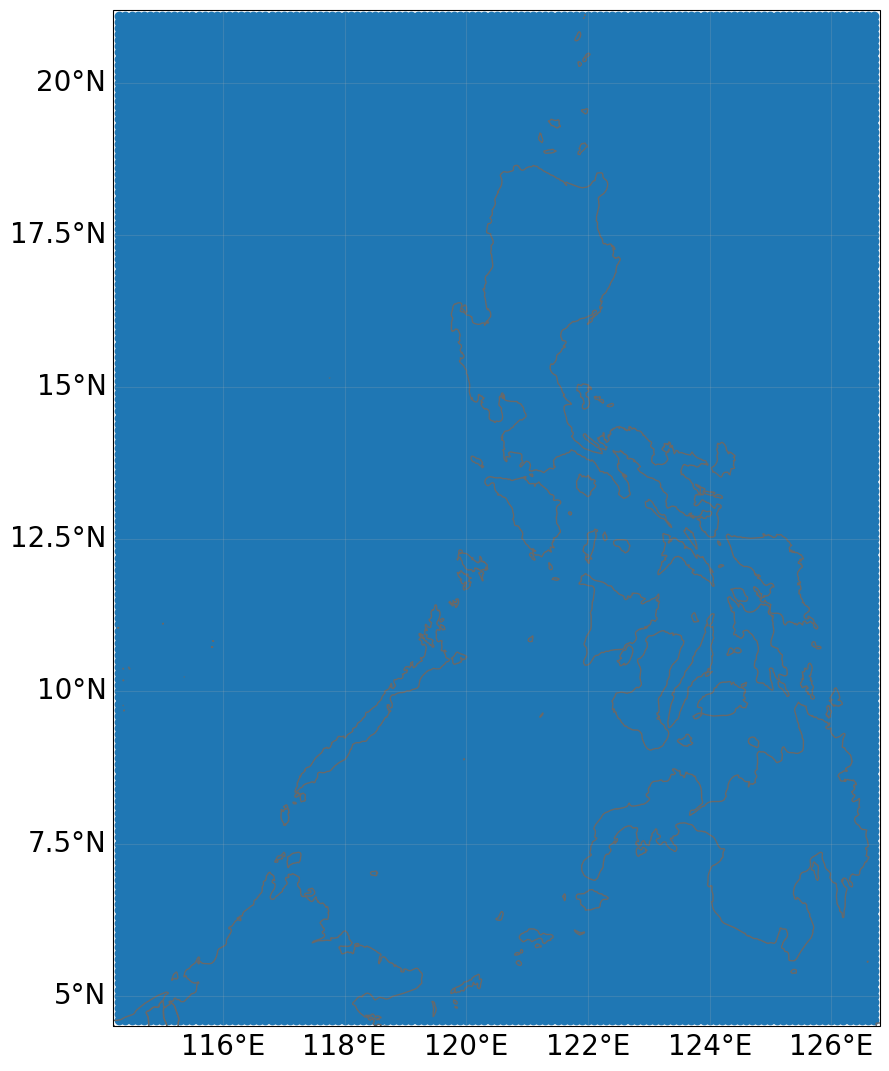

In [386]:
# multipolygon data to centroids

cent = Centroids.from_geodataframe(gpd.read_file(filepath))

cent.check()
cent.plot();

In [387]:
# construct tropical cyclones
tc = TropCyclone.from_tracks(tc_tracks, centroids=cent, store_windfields=True)

2022-11-24 10:45:41,916 - climada.util.plot - WARNING - Error parsing coordinate system 'epsg:4326'. Using projection PlateCarree in plot.


<GeoAxesSubplot:title={'center':'Event ID 7: 2013282N14132'}>

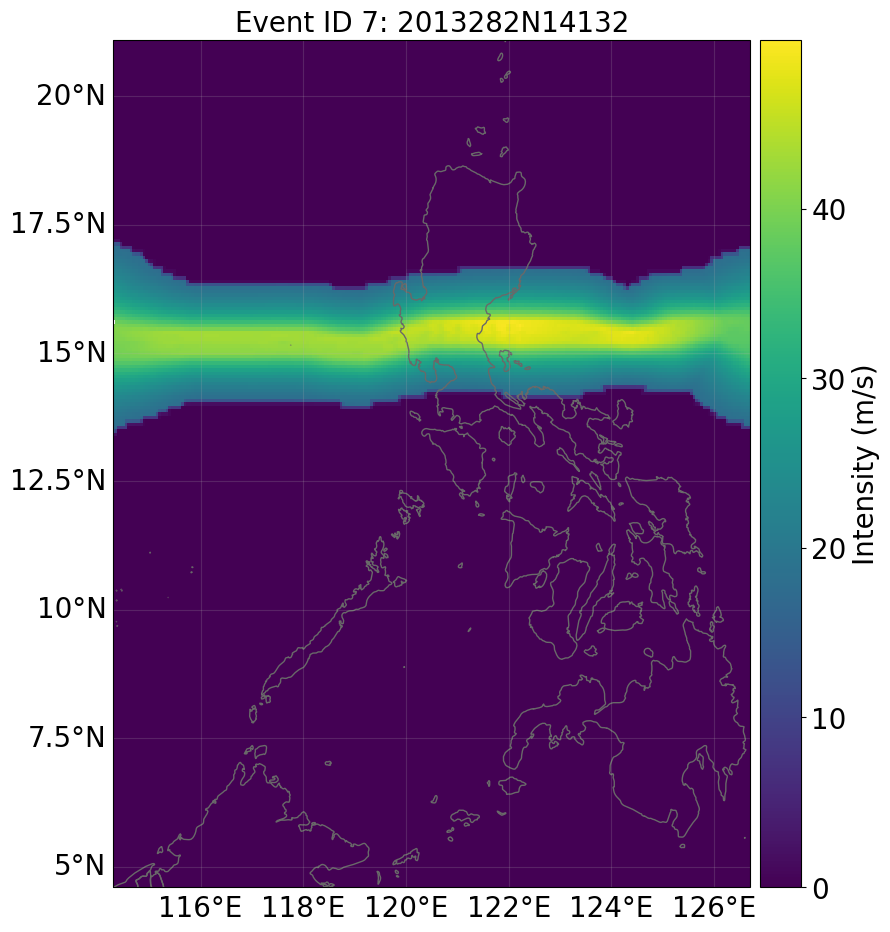

In [389]:
# Let's look at the first typhoon in the dictionary as an example.

for typhoon in typhoons_df:
    id_pplt = typhoons_df.loc[
        typhoons_df["typhoon_name"] == "NARI", "typhoon_id"
    ].iloc[0]

tc.plot_intensity(id_pplt)

In [390]:
# Then calculate windfield
intensity = tc.intensity

In [391]:
tc.intensity

<39x20750 sparse matrix of type '<class 'numpy.float64'>'
	with 132418 stored elements in Compressed Sparse Row format>

In [392]:
windfield_data = intensity.data
display(len(windfield_data))
display(windfield_data)

132418

array([17.68550419, 18.47764793, 19.46302592, ..., 18.71531643,
       18.38318901, 17.93270828])

In [393]:
import scipy.sparse

scipy.sparse.save_npz("sparse_matrix.npz", tc.intensity, compressed=True)

In [394]:
sparse_matrix = scipy.sparse.load_npz("sparse_matrix.npz")

In [395]:
wind_speed = sparse_matrix.toarray()
wind_speed

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [26.11021209, 25.79097958, 25.43851576, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [399]:
# Create a geodataframe

grid_geo = gpd.GeoDataFrame(
    columns=[
        "typhoon_name",
        "typhoon_year",
        "wind_speed",
        "grid_point_id",
        "grid_point_centroid",
    ],
    # geometry="grid_point_centroid",
)

In [400]:
# grid_geo.iloc[0, grid_geo.columns.get_loc("typhoon_name")] = typhoons_df.loc[i, "typhoon_name"]

for i in range(len(wind_speed)):
    grid_geo.at[i, "typhoon_name"] = typhoons_df.loc[i, "typhoon_name"]
    grid_geo.at[i, "typhoon_year"] = typhoons_df.loc[i, "typhoon_year"]
    grid_geo.at[i, "wind_speed"] = wind_speed[i]
    grid_geo.at[i, "grid_point_id"] = gdf.id[:]
    grid_geo.at[i, "grid_point_centroid"] = gdf.geometry[:]
    # geometry_col

grid_geo.head()

,typhoon_name,typhoon_year,wind_speed,grid_point_id,grid_point_centroid
0,DURIAN,2006,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0 1.0 1 2.0 2 ...,0 POINT (114.30000 21.10000) 1 P...
1,FENGSHEN,2008,"[26.110212094776074, 25.790979582866676, 25.43...",0 1.0 1 2.0 2 ...,0 POINT (114.30000 21.10000) 1 P...
2,KETSANA,2009,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0 1.0 1 2.0 2 ...,0 POINT (114.30000 21.10000) 1 P...
3,CONSON,2010,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0 1.0 1 2.0 2 ...,0 POINT (114.30000 21.10000) 1 P...
4,NESAT,2011,"[0.0, 0.0, 0.0, 0.0, 17.88974553461081, 18.607...",0 1.0 1 2.0 2 ...,0 POINT (114.30000 21.10000) 1 P...


In [401]:
# len(grid_geo["wind_speed"][0])
# grid_geo["wind_speed"]